In [36]:
import numpy as np
import galsim
import matplotlib.pyplot as plt

import batsim.transforms as batforms
import batsim.stamp as batstamp
import batsim.pltutil as batplot

from astropy.visualization import simple_norm

## BATSim IA transform set up (Exaggerated IA)

First we will apply some intrinsic shear to a galaxy.

In [130]:
hlr = 4 # half light radius
scale = 0.2 # arcsec per pixel
nn = 128 # number of pixels per image axis
flux = 40

# we will use a simple sersic galaxy and give it intrinsic ellipticity
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux).shear(e1=0.3)

Next, we will use BATSim to define our stamp and transform objects.

In [194]:
# set up an unsheared stamp for comparison
og_stamp = batstamp.Stamp(nn=nn, scale=scale)

# set up the stamp of pixel centers to transform
ia_stamp = batstamp.Stamp(nn=nn, scale=scale)

# we will use an exaggerated IA amplitude to clearly illustrate the effect
IaTransform = batforms.IaTransform(A=0.1, beta=0.8, 
                                    phi=np.radians(60), 
                                    hlr=hlr, scale=scale)

With these objects, we can then transform the stamp grid and sample the sersic gal onto the transformed grid.
The sampled galaxy is returned as an array of flux values.

In [195]:
# transform the ia_stamp
ia_stamp.transform_grids(IaTransform)

# sample the galaxy onto both stamps
og_gal = og_stamp.sample_galaxy(sersic_gal)
ia_gal = ia_stamp.sample_galaxy(sersic_gal)

Next, let's plot the two galaxies to compare.

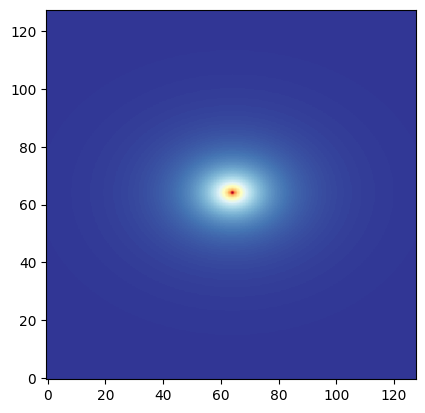

In [196]:
plt.imshow(og_gal, cmap='RdYlBu_r', origin='lower')

Oh dear, that's not very clear! We need some kind of normalisation to make the galaxy appear larger in our image.

In [197]:
# find the flux cuts to best display the galaxies
og_min, og_max = batplot.determine_cuts(og_gal)
ia_min, ia_max = batplot.determine_cuts(ia_gal)

# get normalisations based on optimal the flux cuts
og_sn = simple_norm(og_gal, "asinh", asinh_a=0.1, min_cut=og_min, max_cut=og_max)
ia_sn = simple_norm(ia_gal, "asinh", asinh_a=0.1, min_cut=ia_min, max_cut=ia_max)

Now we can plot the images.

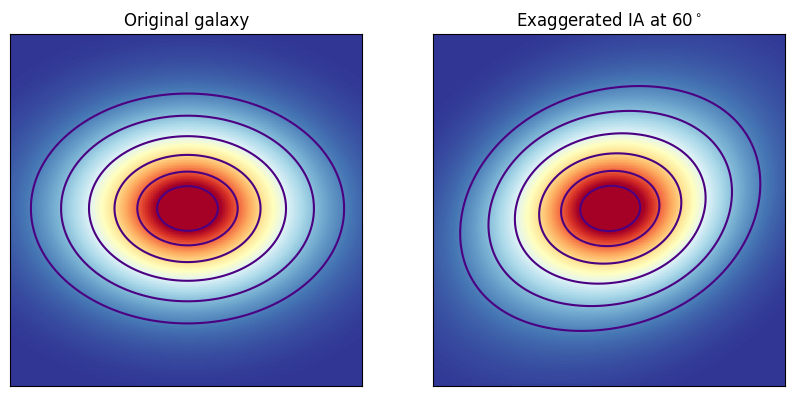

In [198]:
fig, axs = plt.subplots(1,2, figsize=[10,15])

contours = np.geomspace(0.02, 0.5, 6)

for ax in axs:
    ax.set_xticks([]);
    ax.set_yticks([]);

axs[0].imshow(og_gal, norm=og_sn, cmap='RdYlBu_r', origin='lower')
axs[0].contour(og_gal, levels=contours, colors='indigo')
axs[0].set_title('Original galaxy')

axs[1].imshow(ia_gal, norm=ia_sn, cmap='RdYlBu_r', origin='lower')
axs[1].contour(ia_gal, levels=contours, colors='indigo')
axs[1].set_title(r'Exaggerated IA at $60^\circ$')
#plt.savefig('IA_exaggerated_galaxy_compare.png', dpi=300, bbox_inches='tight')

Clearly, we can see that the alignment gets stronger as we go to outer isophotes of the galaxy. But, this is a very exaggerated level of intrinsic alignment, what would it look like for more realistic values?

## Producing an image with realistic IA

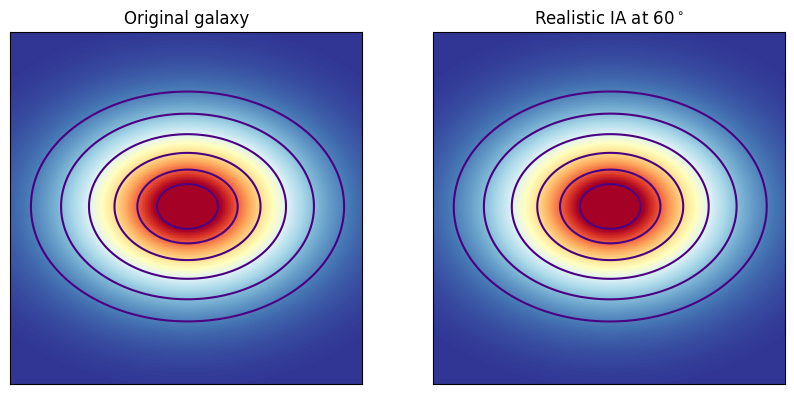

In [187]:
# this is the same code as above, condensed into 1 cell

ia_gal = ia_stamp.sample_galaxy(sersic_gal)
ia_stamp = batstamp.Stamp(nn=nn, scale=scale)
IaTransform = batforms.IaTransform(A=0.001362, beta=0.824, 
                                    phi=np.radians(60), 
                                    hlr=hlr, scale=scale)

ia_stamp.transform_grids(IaTransform)
ia_gal = ia_stamp.sample_galaxy(sersic_gal)

og_min, og_max = batplot.determine_cuts(og_gal)
ia_min, ia_max = batplot.determine_cuts(ia_gal)

og_sn = simple_norm(og_gal, "asinh", asinh_a=0.1, min_cut=og_min, max_cut=og_max)
ia_sn = simple_norm(ia_gal, "asinh", asinh_a=0.1, min_cut=ia_min, max_cut=ia_max)

fig, axs = plt.subplots(1,2, figsize=[10,15])

contours = np.geomspace(0.02, 0.5, 6)

for ax in axs:
    ax.set_xticks([]);
    ax.set_yticks([]);

axs[0].imshow(og_gal, norm=og_sn, cmap='RdYlBu_r', origin='lower')
axs[0].contour(og_gal, levels=contours, colors='indigo')
axs[0].set_title('Original galaxy')

axs[1].imshow(ia_gal, norm=ia_sn, cmap='RdYlBu_r', origin='lower')
axs[1].contour(ia_gal, levels=contours, colors='indigo')
axs[1].set_title(r'Realistic IA at $60^\circ$')
#plt.savefig('IA_realistic_galaxy_compare.png', dpi=300, bbox_inches='tight')

### Residual flux of IA galaxy and original galaxy

Unsurpisingly, its very hard to notice any difference by eye, just like with weak lensing!
However, when we plot the residuals of the two images and normalise again, we can see there is indeed a difference.

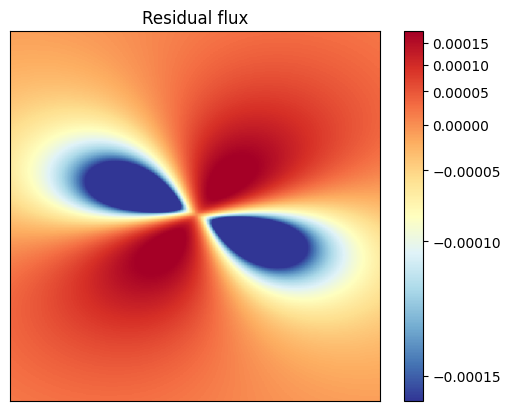

In [193]:
residuals = ia_gal - og_gal
res_min, res_max = batplot.determine_cuts(residuals)
res_sn = simple_norm(residuals, "asinh", asinh_a=0.1, min_cut=res_min, max_cut=res_max)
plt.imshow(residuals, norm=res_sn, cmap='RdYlBu_r', origin='lower')
plt.title('Residual flux')
plt.colorbar()
plt.xticks([]);
plt.yticks([]);
#plt.savefig('IA_residual_flux.png', dpi=300, bbox_inches='tight')

### Comparing to residual flux from a lensing transform

How would these residuals look if our shear had no radial dependence, as seen with typical lensing transforms?

IaTransform has a method which can be used to find the shear at a specific set of coordinates. To compare to lensing, lets find the shear at the half light radius.

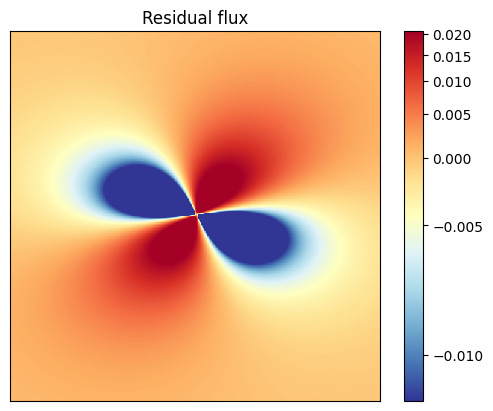

In [205]:
# get the g1 and g2 shear components at hlr
g1, g2 = IaTransform.get_g1g2(hlr,hlr)

# create stamp for lenses galaxy
lens_stamp = batstamp.Stamp(nn=nn, scale=scale)

# we do not include magnification in this case
Lens = batforms.LensTransform(gamma1=g1, gamma2=g2, kappa=0.)
lens_stamp.transform_grids(Lens)
lens_gal = lens_stamp.sample_galaxy(sersic_gal)

residuals = lens_gal - og_gal
res_min, res_max = batplot.determine_cuts(residuals)
res_sn = simple_norm(residuals, "asinh", asinh_a=0.1, min_cut=res_min, max_cut=res_max)
plt.imshow(residuals, norm=res_sn, cmap='RdYlBu_r', origin='lower')
plt.title('Residual flux')
plt.colorbar()
plt.xticks([]);
plt.yticks([]);
#plt.savefig('lensing_residual_flux.png', dpi=300, bbox_inches='tight')